In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [2]:
def load():
    data = pd.read_csv('datasets\hitters.csv')
    return data

df = load()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
df.shape

(322, 20)

### Veri Setini Tanıyalım

* AtBat: 1986-1987 sezonunda bir beyzbol sopası ile topa yapılan vuruş sayısı
* Hits: 1986-1987 sezonundaki isabet sayısı
* HmRun: 1986-1987 sezonundaki en değerli vuruş sayısı
* Runs: 1986-1987 sezonunda takımına kazandırdığı sayı
* RBI: Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı
* Walks: Karşı oyuncuya yaptırılan hata sayısı
* Years: Oyuncunun major liginde oynama süresi (sene)
* CAtBat: Oyuncunun kariyeri boyunca topa vurma sayısı
* CHits: Oyuncunun kariyeri boyunca yaptığı isabetli vuruş sayısı
* CHmRun: Oyucunun kariyeri boyunca yaptığı en değerli sayısı
* CRuns: Oyuncunun kariyeri boyunca takımına kazandırdığı sayı
* CRBI: Oyuncunun kariyeri boyunca koşu yaptırdırdığı oyuncu sayısı
* CWalks: Oyuncun kariyeri boyunca karşı oyuncuya yaptırdığı hata sayısı
* League: Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktör
* Division: 1986 sonunda oyuncunun oynadığı pozisyonu gösteren E ve W seviyelerine sahip bir faktör
* PutOuts: Oyun icinde takım arkadaşınla yardımlaşma
* Assits: 1986-1987 sezonunda oyuncunun yaptığı asist sayısı
* Errors: 1986-1987 sezonundaki oyuncunun hata sayısı
* Salary: Oyuncunun 1986-1987 sezonunda aldığı maaş(bin uzerinden)
* NewLeague: 1987 sezonunun başında oyuncunun ligini gösteren A ve N seviyelerine sahip bir faktör
    
##### Bağımlı değişken : Salary

#### Ana Hedef : Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli gerçekleştirilecektir.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [5]:
# değişkenleri gözlemleyelim
def grab_col_names(dataframe, cat_th=10, car_th=20):
    

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols, num_but_cat

In [6]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [7]:
cat_cols

['League', 'Division', 'NewLeague']

In [8]:
# League : A ve N
# NewLeague : A ve N
# Division : E ve W 

In [9]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [10]:
# Maaşı NaN olanları gözlemleyelim
df[df.Salary.isnull()==True]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
15,183,39,3,20,15,11,3,201,42,3,20,16,11,A,W,118,0,0,NaN,A
18,407,104,6,57,43,65,12,5233,1478,100,643,658,653,A,W,912,88,9,NaN,A
22,22,10,1,4,2,1,6,84,26,2,9,9,3,A,W,812,84,11,NaN,A
30,313,84,9,42,30,39,17,6890,1833,224,1033,864,1087,A,W,127,221,7,NaN,A
32,517,141,27,70,87,52,9,3571,994,215,545,652,337,N,W,1378,102,8,NaN,N
36,161,36,0,19,10,17,4,1053,244,3,156,86,107,A,E,70,149,12,NaN,A
38,346,98,5,31,53,30,16,5913,1615,235,784,901,560,A,E,0,0,0,NaN,A
39,241,61,1,34,12,14,1,241,61,1,34,12,14,N,W,166,172,10,NaN,N
41,216,54,0,21,18,15,18,7318,1926,46,796,627,483,N,W,103,84,5,NaN,N


In [11]:
# Eksik değerler bağımlı değişkende olduğu için bunları silmeyi tercih edebiliriz.

In [12]:
df.dropna(inplace=True)
df.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

In [13]:
# Kategorik değişken analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
    print('####################################################')

In [14]:
for col in cat_cols:
    cat_summary(df, col)

   League      Ratio
A     139  52.851711
N     124  47.148289
####################################################
   Division     Ratio
W       134  50.95057
E       129  49.04943
####################################################
   NewLeague      Ratio
A        141  53.612167
N        122  46.387833
####################################################


In [15]:
# Nümerik değişken analizi
df.describe([0.05, 0.50, 0.95, 0.99]).T

,count,mean,std,min,5%,50%,95%,99%,max
AtBat,263.0,403.642586,147.307209,19.0,181.3,413.0,617.8,668.32000,687.0
Hits,263.0,107.828897,45.125326,1.0,42.1,103.0,177.9,211.76000,238.0
HmRun,263.0,11.619772,8.757108,0.0,1.0,9.0,29.0,33.00000,40.0
Runs,263.0,54.745247,25.539816,0.0,19.1,52.0,96.8,111.42000,130.0
RBI,263.0,51.486692,25.882714,0.0,18.0,47.0,99.8,114.14000,121.0
Walks,263.0,41.114068,21.718056,0.0,12.0,37.0,78.9,94.00000,105.0
Years,263.0,7.311787,4.793616,1.0,1.0,6.0,16.9,19.38000,24.0
CAtBat,263.0,2657.543726,2286.582929,19.0,279.9,1931.0,7120.1,8732.34000,14053.0
CHits,263.0,722.186312,648.199644,4.0,68.0,516.0,2023.5,2481.48000,4256.0
CHmRun,263.0,69.239544,82.197581,0.0,2.0,40.0,258.4,348.52000,548.0


In [16]:
# kategorik değişkenlere göre hedef değişkenin ortalaması.
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

In [17]:
for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

League
   TARGET_MEAN  Count      Ratio
A   541.999547    139  52.851711
N   529.117500    124  47.148289


Division
   TARGET_MEAN  Count     Ratio
E   624.271364    129  49.04943
W   450.876873    134  50.95057


NewLeague
   TARGET_MEAN  Count      Ratio
A   537.113028    141  53.612167
N   534.553852    122  46.387833




In [18]:
# korelasyonu inceleyelim
corr = df[num_cols].corr()
corr

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.000000,0.963969,0.555102,0.899829,0.796015,0.624448,0.012725,0.207166,0.225341,0.212422,0.237278,0.221393,0.132926,0.309607,0.342117,0.325577,0.394771
Hits,0.963969,1.000000,0.530627,0.910630,0.788478,0.587311,0.018598,0.206678,0.235606,0.189364,0.238896,0.219384,0.122971,0.299688,0.303975,0.279876,0.438675
HmRun,0.555102,0.530627,1.000000,0.631076,0.849107,0.440454,0.113488,0.217464,0.217496,0.492526,0.258347,0.349858,0.227183,0.250931,-0.161602,-0.009743,0.343028
Runs,0.899829,0.910630,0.631076,1.000000,0.778692,0.697015,-0.011975,0.171811,0.191327,0.229701,0.237831,0.202335,0.163700,0.271160,0.179258,0.192609,0.419859
RBI,0.796015,0.788478,0.849107,0.778692,1.000000,0.569505,0.129668,0.278126,0.292137,0.442190,0.307226,0.387777,0.233619,0.312065,0.062902,0.150155,0.449457
Walks,0.624448,0.587311,0.440454,0.697015,0.569505,1.000000,0.134793,0.269450,0.270795,0.349582,0.332977,0.312697,0.429140,0.280855,0.102523,0.081937,0.443867
Years,0.012725,0.018598,0.113488,-0.011975,0.129668,0.134793,1.000000,0.915681,0.897844,0.722371,0.876649,0.863809,0.837524,-0.020019,-0.085118,-0.156512,0.400657
CAtBat,0.207166,0.206678,0.217464,0.171811,0.278126,0.269450,0.915681,1.000000,0.995057,0.801676,0.982747,0.950730,0.906712,0.053393,-0.007897,-0.070478,0.526135
CHits,0.225341,0.235606,0.217496,0.191327,0.292137,0.270795,0.897844,0.995057,1.000000,0.786652,0.984542,0.946797,0.890718,0.067348,-0.013144,-0.068036,0.548910
CHmRun,0.212422,0.189364,0.492526,0.229701,0.442190,0.349582,0.722371,0.801676,0.786652,1.000000,0.825625,0.927903,0.810878,0.093822,-0.188886,-0.165369,0.524931


<AxesSubplot:>

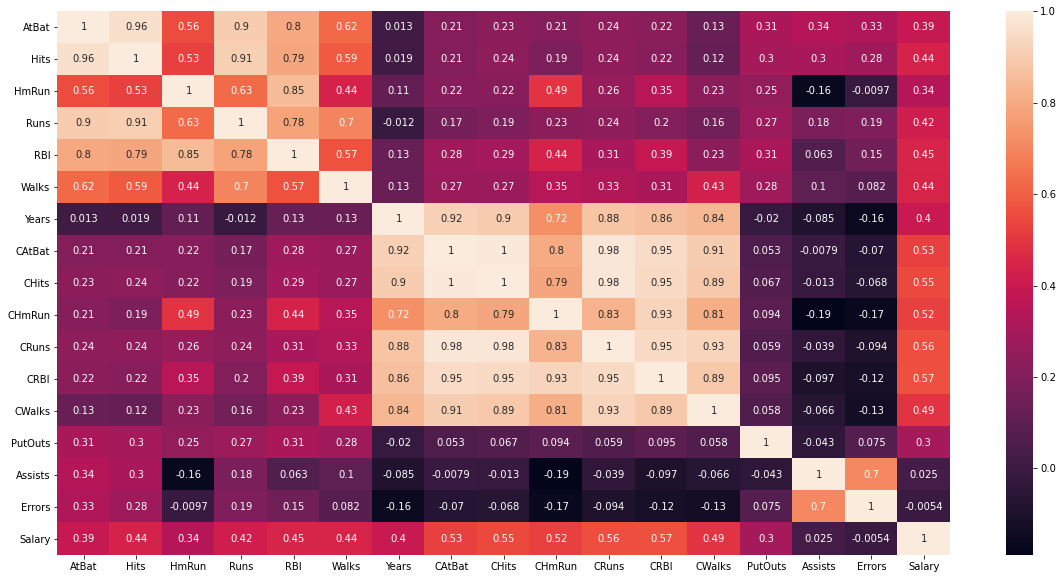

In [19]:
df.corrwith(df["Salary"]).sort_values(ascending=False)
corr_df = df.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_df, annot=True)

### Aykırı değer analizi

In [20]:
#eşik değer hesapla
def outlier_thresholds(dataframe, col_name, q1=0.5, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [21]:
# outlier'ları kontrol et
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat True
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


In [23]:
# Aykırı değerlerin kendilerine erişip gözlemle
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [24]:
for col in num_cols:
    print(col, grab_outliers(df,col))

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
217     20     1      0     0    0      0      2      41      9       2   
295     19     4      1     2    3      1      1      19      4       1   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors    Salary  \
217      6     7       4      N        E       78      220       6  2127.333   
295      2     3       1      N        W      692       70       8   920.000   

    NewLeague  
217         N  
295         A  
AtBat None
Empty DataFrame
Columns: [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks, League, Division, PutOuts, Assists, Errors, Salary, NewLeague]
Index: []
Hits None
Empty DataFrame
Columns: [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks, League, Division, PutOuts, Assists, Errors, Salary, NewLeague]
Index: []
HmRun None
Empty DataFrame
Columns: [AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat

In [25]:
# aykırı değerler için baskılama çözümü
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [26]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [27]:
# şimdi tekrar aykırı değer kontrolü yapalım.
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


### Encoding

In [28]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

In [29]:
binary_cols

['League', 'Division', 'NewLeague']

In [30]:
for i in binary_cols:
    df[i] = le.fit_transform(df[i])

In [31]:
# One hot encoding
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df=pd.get_dummies(df, columns=ohe_cols)

In [32]:
ohe_cols

[]

In [33]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,1,1,632.0,43.0,10.0,475.0,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,0,1,880.0,82.0,14.0,480.0,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,1,0,200.0,11.0,3.0,500.0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,1,0,805.0,40.0,4.0,91.5,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,0,1,282.0,421.0,25.0,750.0,0


In [34]:
# standartlaştırma
scaler = RobustScaler()
num_cols = [col for col in num_cols  if col not in ["Salary"]]

df[num_cols] = scaler.fit_transform(df[num_cols])

In [35]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-0.402464,-0.314286,-0.153846,-0.708861,-0.219512,0.058824,1.333333,0.498031,0.378860,0.374194,0.181122,0.558422,0.780583,1,1,1.952153,-0.010870,0.3,475.0,1
2,0.271047,0.385714,0.692308,0.354430,0.609756,1.147059,-0.500000,-0.100722,-0.070071,0.296774,-0.066327,0.109256,0.345631,0,1,3.138756,0.201087,0.7,480.0,0
3,0.340862,0.542857,0.846154,0.329114,0.756098,0.000000,0.833333,1.212927,1.257720,2.387097,1.474490,1.845220,0.699029,1,0,-0.114833,-0.184783,-0.4,500.0,1
4,-0.377823,-0.228571,0.076923,-0.329114,-0.121951,-0.205882,-0.666667,-0.503609,-0.492874,-0.361290,-0.515306,-0.558422,-0.547573,1,0,2.779904,-0.027174,-0.3,91.5,1
5,0.743326,0.942857,-0.384615,0.556962,0.097561,-0.058824,0.833333,0.812664,0.732779,-0.270968,0.640306,0.321700,0.077670,0,1,0.277512,2.043478,1.8,750.0,0


## BASE MODEL KURALIM

#### feature engineering işlemlerinden önce doğruluk değerlerimizi gözlemleyelim.

In [36]:
from sklearn.linear_model import LinearRegression
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [38]:
reg_model = LinearRegression().fit(X_train, y_train)

In [39]:
y_pred = reg_model.predict(X_train)

In [40]:
print("Train  MSE:", "{:,.2f}".format(mean_squared_error(y_train, y_pred)), "\n")

print("Train RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train, y_pred))), "\n")

print("Train MAE:", "{:,.2f}".format(mean_absolute_error(y_train, y_pred)), "\n")
      
print("Train R^2:", "{:,.2f}".format(r2_score(y_train, y_pred)))  

Train  MSE: 86,000.32 

Train RMSE: 293.26 

Train MAE: 214.19 

Train R^2: 0.59


In [41]:
y_pred = reg_model.predict(X_test)

In [42]:
print("Test  MSE:", "{:,.2f}".format(mean_squared_error(y_test, y_pred)), "\n")

print("Test RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))), "\n")

print("Test MAE:", "{:,.2f}".format(mean_absolute_error(y_test, y_pred)), "\n")
      
print("Test R^2:", "{:,.2f}".format(r2_score(y_test, y_pred)))   #reg_model.score(X_test, y_test)

Test  MSE: 137,397.12 

Test RMSE: 370.67 

Test MAE: 212.95 

Test R^2: 0.24


In [43]:
# sabit (b - bias)
reg_model.intercept_

411.48139234180906

In [44]:
# coefficients (w - weights)
reg_model.coef_

array([-275.00826851,  455.575085  ,   65.12950387, -113.57817351,
        -70.03954199,  179.41370491,   55.10863839, -798.92491943,
        183.82244964,  -37.54214401,  639.19522926,  316.55585729,
       -199.158866  ,  116.85373023, -115.25411275,   51.83305593,
         40.06672979,   -9.25524508,  -72.78988497])

In [45]:
np.mean(np.sqrt(-cross_val_score(reg_model, X, y, cv=10, scoring="neg_mean_squared_error")))

333.43547304294

# Feature Engineering

In [46]:
df = load()

In [47]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [48]:
# aykırı değerleri baskıla
for col in num_cols:
    replace_with_thresholds(df, col)

In [49]:
# eksik değerleri sil.
df.dropna(inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    float64
 1   Hits       263 non-null    float64
 2   HmRun      263 non-null    float64
 3   Runs       263 non-null    float64
 4   RBI        263 non-null    float64
 5   Walks      263 non-null    float64
 6   Years      263 non-null    float64
 7   CAtBat     263 non-null    float64
 8   CHits      263 non-null    float64
 9   CHmRun     263 non-null    float64
 10  CRuns      263 non-null    float64
 11  CRBI       263 non-null    float64
 12  CWalks     263 non-null    float64
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    float64
 16  Assists    263 non-null    float64
 17  Errors     263 non-null    float64
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [51]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 263
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [52]:
df[num_cols] = df[num_cols] + 1

In [53]:
df["NEW_Hits_AtBat"] = df["Hits"] / df["AtBat"]
df["NEW_HmRun_AtBat"] = df["HmRun"] / df["AtBat"]
df["NEW_HmRun_Hits"] = df["HmRun"] / df["Hits"]
df["NEW_Assists_ratio"] = df["Assists"] / df["AtBat"]

In [54]:
df["NEW_Runs_Ratio"] = df["Runs"] / df["CRuns"]
df["NEW_Atbat_Ratio"] = df["AtBat"] / df["CAtBat"]
df["NEW_Hits_Ratio"] = df["Hits"] / df["CHits"]
df["NEW_HmRun_Ratio"] = df["HmRun"] / df["CHmRun"]

In [55]:
df["NEW_CHits_CAtBat"] = df["CHits"] / df["CAtBat"]

In [56]:
df["NEW_CAtBat_mean"] = df["CAtBat"] / df["Years"]
df["NEW_CHits_mean"] = df["CHits"] / df["Years"]
df["NEW_CHmRun_mean"] = df["CHmRun"] / df["Years"]
df["NEW_CRuns_mean"] = df['CRuns'] / df["Years"]
df["NEW_CRBI_mean"] = df["CRBI"] / df["Years"]
df["NEW_CWalks_mean"] = df["CWalks"] / df["Years"]

In [57]:
df.loc[(df["Years"] <= 2), "NEW_Years_level"] = "Junior"
df.loc[(df["Years"] > 2) & (df['Years'] <= 5), "NEW_Years_level"] = "Mid"
df.loc[(df["Years"] > 5) & (df['Years'] <= 10), "NEW_Years_level"] = "Senior"
df.loc[(df["Years"] > 10), "NEW_Years_level"] = "Expert"

In [58]:
df.loc[(df["League"] == "N") & (df["NewLeague"] == "N"), "NEW_Progress"] = "StandN"
df.loc[(df["League"] == "A") & (df["NewLeague"] == "A"), "NEW_Progress"] = "StandA"
df.loc[(df["League"] == "N") & (df["NewLeague"] == "A"), "NEW_Progress"] = "Descend"
df.loc[(df["League"] == "A") & (df["NewLeague"] == "N"), "NEW_Progress"] = "Ascend"

In [59]:
df["NEW_Player_Season_Success"] = (df["AtBat"] * 4 / 100 + df["Hits"] * 10 / 100 + df["HmRun"] * 12 / 100 +df["Runs"] * 12 / 100 + df["RBI"] * 10 / 100 + df["Walks"] * 12 / 100 + df["Assists"] * 10 / 100 +df["PutOuts"] * 10 / 100 - df["Errors"] * 20 / 100)

In [60]:
df.shape

(263, 38)

In [61]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,NEW_Hits_AtBat,NEW_HmRun_AtBat,NEW_HmRun_Hits,NEW_Assists_ratio,NEW_Runs_Ratio,NEW_Atbat_Ratio,NEW_Hits_Ratio,NEW_HmRun_Ratio,NEW_CHits_CAtBat,NEW_CAtBat_mean,NEW_CHits_mean,NEW_CHmRun_mean,NEW_CRuns_mean,NEW_CRBI_mean,NEW_CWalks_mean,NEW_Years_level,NEW_Progress,NEW_Player_Season_Success
1,316.0,82.0,8.0,25.0,39.0,40.0,15.0,3450.0,836.0,70.0,322.0,415.0,376.0,N,W,633.0,44.0,11.0,476.0,N,0.259494,0.025316,0.097561,0.139241,0.077640,0.091594,0.098086,0.114286,0.242319,230.000000,55.733333,4.666667,21.466667,27.666667,25.066667,Expert,StandN,99.00
2,480.0,131.0,19.0,67.0,73.0,77.0,4.0,1625.0,458.0,64.0,225.0,267.0,264.0,A,W,881.0,83.0,15.0,481.0,A,0.272917,0.039583,0.145038,0.172917,0.297778,0.295385,0.286026,0.296875,0.281846,406.250000,114.500000,16.000000,56.250000,66.750000,66.000000,Mid,StandA,152.56
3,497.0,142.0,21.0,66.0,79.0,38.0,12.0,5629.0,1576.0,226.0,829.0,839.0,355.0,N,E,201.0,12.0,4.0,501.0,N,0.285714,0.042254,0.147887,0.024145,0.079614,0.088293,0.090102,0.092920,0.279979,469.083333,131.333333,18.833333,69.083333,69.916667,29.583333,Expert,StandN,77.48
4,322.0,88.0,11.0,40.0,43.0,31.0,3.0,397.0,102.0,13.0,49.0,47.0,34.0,N,E,806.0,41.0,5.0,92.5,N,0.273292,0.034161,0.125000,0.127329,0.816327,0.811083,0.862745,0.846154,0.256927,132.333333,34.000000,4.333333,16.333333,15.666667,11.333333,Mid,StandN,119.52
5,595.0,170.0,5.0,75.0,52.0,36.0,12.0,4409.0,1134.0,20.0,502.0,337.0,195.0,A,W,283.0,422.0,26.0,751.0,A,0.285714,0.008403,0.029412,0.709244,0.149402,0.134951,0.149912,0.250000,0.257201,367.416667,94.500000,1.666667,41.833333,28.083333,16.250000,Expert,StandA,125.22


In [62]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 263
Variables: 38
cat_cols: 5
num_cols: 33
cat_but_car: 0
num_but_cat: 0


In [63]:
cat_cols

['League', 'Division', 'NewLeague', 'NEW_Years_level', 'NEW_Progress']

In [64]:
# şimdi tekrar aykırı değer kontrolü yapalım.
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat True
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False
NEW_Hits_AtBat True
NEW_HmRun_AtBat False
NEW_HmRun_Hits True
NEW_Assists_ratio True
NEW_Runs_Ratio False
NEW_Atbat_Ratio False
NEW_Hits_Ratio False
NEW_HmRun_Ratio False
NEW_CHits_CAtBat True
NEW_CAtBat_mean False
NEW_CHits_mean False
NEW_CHmRun_mean False
NEW_CRuns_mean False
NEW_CRBI_mean False
NEW_CWalks_mean False
NEW_Player_Season_Success False


In [65]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [66]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

In [67]:
binary_cols

['League', 'Division', 'NewLeague']

In [68]:
for i in binary_cols:
    df[i] = le.fit_transform(df[i])

In [69]:
# One hot encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [70]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['NEW_Years_level', 'NEW_Progress']

In [71]:
df = one_hot_encoder(df, ohe_cols)

In [72]:
df.shape

(263, 44)

In [73]:
# standartlaştırma
scaler = RobustScaler()
num_cols = [col for col in num_cols  if col not in ["Salary"]]

df[num_cols] = scaler.fit_transform(df[num_cols])

In [74]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,NEW_Hits_AtBat,NEW_HmRun_AtBat,NEW_HmRun_Hits,NEW_Assists_ratio,NEW_Runs_Ratio,NEW_Atbat_Ratio,NEW_Hits_Ratio,NEW_HmRun_Ratio,NEW_CHits_CAtBat,NEW_CAtBat_mean,NEW_CHits_mean,NEW_CHmRun_mean,NEW_CRuns_mean,NEW_CRBI_mean,NEW_CWalks_mean,NEW_Player_Season_Success,NEW_Years_level_Expert,NEW_Years_level_Junior,NEW_Years_level_Mid,NEW_Years_level_Senior,NEW_Progress_Ascend,NEW_Progress_Descend,NEW_Progress_StandA,NEW_Progress_StandN
1,-0.402464,-0.314286,-0.153846,-0.708861,-0.219512,0.058824,1.333333,0.498031,0.378860,0.374194,0.181122,0.558422,0.780583,1,1,1.952153,-0.010870,0.3,476.0,1,-0.134379,-0.185716,-0.146916,-0.036143,-0.397759,-0.364140,-0.326636,-0.434834,-0.659738,-0.215369,-0.299663,-0.117822,-0.505876,-0.100577,0.081437,0.393449,1,0,0,0,0,0,0,1
2,0.271047,0.385714,0.692308,0.354430,0.609756,1.147059,-0.500000,-0.100722,-0.070071,0.296774,-0.066327,0.109256,0.345631,0,1,3.138756,0.201087,0.7,481.0,0,0.258527,0.345628,0.314555,0.026225,0.212799,0.270507,0.237538,0.080701,0.608815,0.628158,0.713713,1.296040,0.626917,1.286792,2.209197,1.413445,0,0,1,0,0,0,1,0
3,0.340862,0.542857,0.846154,0.329114,0.756098,0.000000,0.833333,1.212927,1.257720,2.387097,1.474490,1.845220,0.699029,1,0,-0.114833,-0.184783,-0.4,501.0,1,0.633127,0.445074,0.342248,-0.249300,-0.392283,-0.374421,-0.350605,-0.495158,0.548882,0.928877,1.003988,1.649505,1.044862,1.399201,0.316218,-0.016378,1,0,0,0,0,0,0,1
4,-0.377823,-0.228571,0.076923,-0.329114,-0.121951,-0.205882,-0.666667,-0.503609,-0.492874,-0.361290,-0.515306,-0.558422,-0.547573,1,0,2.779904,-0.027174,-0.3,92.5,1,0.269511,0.143701,0.119787,-0.058203,1.651006,1.876501,1.968778,1.631572,-0.190919,-0.682798,-0.674434,-0.159406,-0.673054,-0.526549,-0.632437,0.784232,0,0,1,0,0,0,0,1
5,0.743326,0.942857,-0.384615,0.556962,0.097561,-0.058824,0.833333,0.812664,0.732779,-0.270968,0.640306,0.321700,0.077670,0,1,0.277512,2.043478,1.8,751.0,0,0.633127,-0.815613,-0.809317,1.019502,-0.198724,-0.229117,-0.171061,-0.051649,-0.182118,0.442303,0.368831,-0.492079,0.157408,-0.085786,-0.376863,0.892782,1,0,0,0,0,0,1,0


## Model

#### Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [76]:
# holdout 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [77]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [78]:
y_pred = reg_model.predict(X_train)

In [79]:
print("Train  MSE:", "{:,.2f}".format(mean_squared_error(y_train, y_pred)), "\n")

print("Train RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train, y_pred))), "\n")

print("Train MAE:", "{:,.2f}".format(mean_absolute_error(y_train, y_pred)), "\n")
      
print("Train R^2:", "{:,.2f}".format(r2_score(y_train, y_pred))) 

Train  MSE: 52,452.77 

Train RMSE: 229.03 

Train MAE: 162.39 

Train R^2: 0.75


In [80]:
#Train  MSE: 86,000.32 
#Train RMSE: 293.26 
#Train MAE: 214.19 
#Train R^2: 0.59

In [81]:
y_pred = reg_model.predict(X_test)

In [82]:
print("Test  MSE:", "{:,.2f}".format(mean_squared_error(y_test, y_pred)), "\n")

print("Test RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))), "\n")

print("Test MAE:", "{:,.2f}".format(mean_absolute_error(y_test, y_pred)), "\n")
      
print("Test R^2:", "{:,.2f}".format(r2_score(y_test, y_pred)))

Test  MSE: 100,455.85 

Test RMSE: 316.95 

Test MAE: 198.21 

Test R^2: 0.44


In [83]:
#Test  MSE: 137,397.12 
#Test RMSE: 370.67 
#Test MAE: 212.95 
#Test R^2: 0.24

In [84]:
# cross validation
np.mean(np.sqrt(-cross_val_score(reg_model, X, y, cv=10, scoring="neg_mean_squared_error")))

301.99683195186304

In [ ]:
# 333.4354   --->  301.9968